In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

In [53]:
dataset_path = "/home/nkd/ouyangzl/Diffusion Model/data"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = 'MNIST'
img_size = (32, 32, 3) if dataset == "CFAR10" else (28, 28, 1)  # (width, height, channels)

timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

train_batch_size = 128
inference_batch_size = 64
lr = 5e-5
epochs = 200

seed = 1234

hidden_dims = [hidden_dim for _ in range(n_layers)]
torch.manual_seed(seed)
np.random.seed(seed)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [4]:
print(DEVICE)

cuda


## Step 1. Load (or download) Dataset

In [5]:

from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
])
kwargs = {'num_workers': 1, 'pin_memory': True}

if dataset == 'CIFAR10':
    train_dataset = CIFAR10(dataset_path, transform=transform, train=True, download=True)
    test_dataset = CIFAR10(dataset_path, transform=transform, train=False, download=True)
else:
    train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
    test_dataset = MNIST(dataset_path, transform=transform, train=False, download=True)
    
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=test_dataset, batch_size=inference_batch_size, shuffle=False, **kwargs)

## Step 2. Define our model: Denoising Diffusion Probabilistic Models (DDPMs)

Sinusoidal embedding for diffusion timestep

In [6]:
def sinusoidal_position_encoding(seq_len, d_model):
    """
    生成Sinusoidal位置编码矩阵
    Args:
        seq_len (int): 序列最大长度
        d_model (int): 模型维度
    Returns:
        pe (torch.Tensor): 形状为 (seq_len, d_model) 的位置编码矩阵
    """
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe

    

In [7]:
# 示例参数
seq_len = 5  # 序列长度
d_model = 4  # 模型维度
# 生成位置编码
pe = sinusoidal_position_encoding(seq_len, d_model)
print("位置编码矩阵：\n", pe)

位置编码矩阵：
 tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996],
        [-0.7568, -0.6536,  0.0400,  0.9992]])


In [21]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super(SinusoidalPosEmb, self).__init__()
        self.dim=dim
    
    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [22]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """
    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0., stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        if padding == 'same':
            padding = kernel_size // 2 * dilation
        
        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        
        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None
    
    def forward(self, x, time_embedding=None, residual=False):
        if residual:
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y
        
        return y
        

In [48]:
class Denoiser(nn.Module):
    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim=256, n_times=1000):
        super(Denoiser, self).__init__()
        
        _, _, img_C = image_resolution
        
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)
        
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)
        
        self.time_project = nn.Sequential(
            ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
            ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1)
        )
        
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])
        
        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx - 1], hidden_dims[idx], kernel_size=3, dilation=3 ** ((idx - 1) // 2), activation_fn=True, gn=True, gn_groups=8))
        
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)
    
    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x
        print(y.shape)
        
        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))
        
        y = self.in_project(y)
        
        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual=True)
            print(y.shape)
        y = self.out_project(y)
        
        return y
    
model = Denoiser(image_resolution=img_size,
                 hidden_dims=hidden_dims,
                 diffusion_time_embedding_dim=timestep_embedding_dim,
                 n_times=n_timesteps
                 ).to(DEVICE)
    

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Define Gaussian Diffusion

In [47]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):
        super(Diffusion, self).__init__()
        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution
        self.model = model
        
        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device)
        self.sqrt_betas = torch.sqrt(betas)
        
        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas) 
        alpha_bars = torch.cumprod(self.alphas, dim=0)  # 累积乘积（cumulative product），它将 self.alphas 中的每个元素与前一个元素的积相乘，从而生成一个新数组 alpha_bars
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)
        
        self.device = device
        
    def extract(self, a, t, x_shape):
        """
            from lucidrains' implementation
                https://github.com/lucidrains/denoising-diffusion-pytorch/blob/beb2f2d8dd9b4f2bd5be4719f37082fe061ee450/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py#L376
        """
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))
    
    def scale_to_minus_one_to_one(self, x):
        return x * 2 - 1
    
    def reverse_scale_to_zero_to_one(self, x):
        return (x+1)*0.5
    
    def make_noise(self, x_zeros, t):
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)
        
        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)
        
        # Let's make noisy sample!: i.e., Forward process with fixed variance schedule
        #      i.e., sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar
        
        return noisy_sample.detach(), epsilon
    
    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)
        
        B, _, _, _ = x_zeros.shape
        
        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)
        
        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noise(x_zeros, t)
        
        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)
        
        return perturbed_images, epsilon, pred_epsilon
    
    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)
        
        if t == 0:
            return x_t.clamp(-1, 1)
    
        
        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)
        
        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        
        
        sqrt_one_minus_alpha_bar_pre = self.extract(self.sqrt_one_minus_alpha_bars, timestep - 1, x_t.shape)
        sigma = torch.sqrt((1 - alpha) * (sqrt_one_minus_alpha_bar) / sqrt_one_minus_alpha_bar_pre)
        # denoise at time t, utilizing predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1 - alpha) / sqrt_one_minus_alpha_bar * epsilon_pred) +  sigma * z
        
        return x_t_minus_1.clamp(-1, 1)

    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)
        
        # autoregressively denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times - 1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)
        
        x_0 = self.reverse_scale_to_zero_to_one(x_t)
        
        return x_0

diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps, beta_minmax=beta_minmax, device=DEVICE).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of model paramters: ", count_parameters(diffusion))

Number of model paramters:  4870913


## Visualizing forward process##

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 1, 1])
torch.Size([64, 1, 1, 1])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 256, 28, 28])
torch.Size([64, 256, 28, 28])
torch.Size([64, 256, 28, 28])
torch.Size([64, 256, 28, 28])
torch.Size([64, 256, 28, 28])
torch.Size([64, 256, 28, 28])
torch.Size([64, 256, 28, 28])
torch.Size([64, 256, 28, 28])


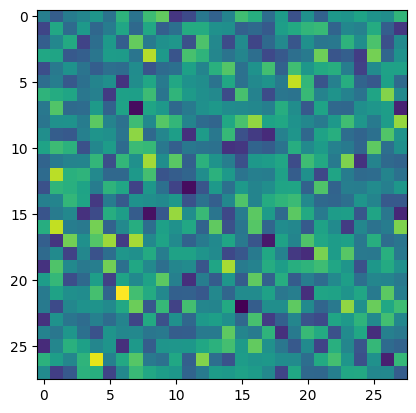

In [42]:
model.eval()
for batch_idx, (x, _) in enumerate(test_loader):
    x = x.to(DEVICE)
    print(x.shape)
    perturbed_images, epsilon, pred_epsilon = diffusion(x)
    perterbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    break

def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
    
show_image(perturbed_images, idx=0)

In [30]:
print(perterbed_images.shape)

torch.Size([64, 1, 28, 28])


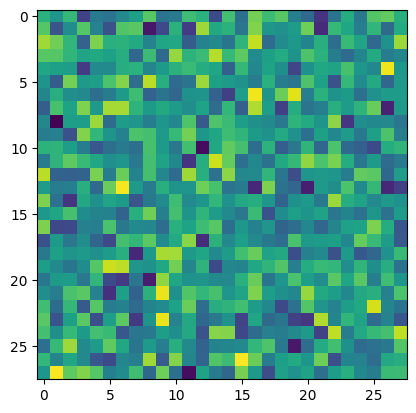

In [31]:
show_image(perturbed_images, idx=1)

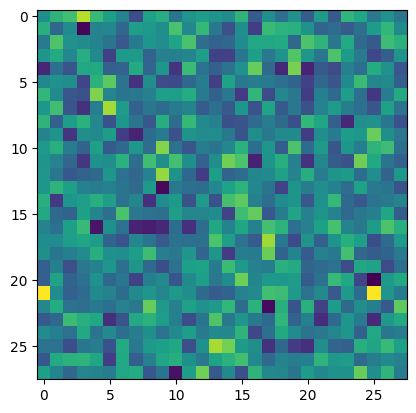

In [34]:
show_image(perturbed_images, idx=4)


## Step 3. Train Denoising Diffusion Probabilistic Models(DDPMs)

In [45]:

print("Start training DDPMs...")
model.train()

for epoch in range(epochs):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()
        print('Gradient have been cleared')
        
        x = x.to(DEVICE)
        
        noise_input, epsilon, pred_epsilon = diffusion(x)
        loss = denoising_loss(pred_epsilon, epsilon)
        print(f'Loss: {loss}')
        
        noise_prediction_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        print('Parameters Optimized !')
        
        model.eval()
        with torch.no_grad():
            generated_images = diffusion.sample(1)
            
        show_image(generated_images, idx=0)
        model.train()

    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / batch_idx)
    
print("Finish!!")

Start training DDPMs...


  0%|          | 0/469 [00:00<?, ?it/s]

Gradient have been cleared
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 256, 28, 28])
torch.Size([128, 256, 28, 28])
torch.Size([128, 256, 28, 28])
torch.Size([128, 256, 28, 28])
torch.Size([128, 256, 28, 28])
torch.Size([128, 256, 28, 28])
torch.Size([128, 256, 28, 28])
torch.Size([128, 256, 28, 28])
Loss: 0.07180115580558777
Parameters Optimized !
torch.Size([1, 1, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 256,

  0%|          | 0/469 [00:02<?, ?it/s]

torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28


/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [0,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


<Figure size 640x480 with 0 Axes>

In [35]:
print(epochs)

200


## Step 4. Sample images from noise

In [46]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
